In [15]:
import os
import pandas as pd
import sqlite3
import requests
import matplotlib.pyplot as plt
import currency_rate_extractor
from dotenv import load_dotenv
from pathlib import Path

api_key = os.getenv('ROOT')

## Api test (Skippable)

In [17]:
base_currency = "USD"
url_currency_rates = f"https://v6.exchangerate-api.com/v6/{api_key}/latest/{base_currency}"
req_currency = requests.get(url_currency_rates)

data = req_currency.json()

# Extract conversion rates and create DataFrame
conversion_rates = pd.DataFrame(data['conversion_rates'].items(), columns=['Currency_Code', 'Rate'])

# Sort DataFrame by Rate in descending order
highest_rates = conversion_rates.sort_values(by="Rate", ascending=False).reset_index(drop=True)
highest_rates["date"] = data["time_last_update_utc"].split(" 00:")[0]
highest_rates.head()

KeyError: 'conversion_rates'

- **Improvement**: Add country names from this site (quick scraping) https://www.foreignexchangelive.com/currency-codes-symbols/

In [ ]:
url_currency_codes = f'https://v6.exchangerate-api.com/v6/{api_key}/codes'
req_codes = requests.get(url_currency_codes)
data_code = req_codes.json()
codes = pd.DataFrame(data_code["supported_codes"], columns=["Currency_Code", "Currency_Name"])

## Manipulating the sqlite3 database

In [ ]:
import sqlite3
# Create a sqlite3 database
conn = sqlite3.connect(Path(ROOT / 'data' / 'currency_rates.db'))
c = conn.cursor()

# Query the database, show tables
c.execute('''
SELECT name
FROM sqlite_master
WHERE type='table'
''')

print(c.fetchall())

[('currency_names',), ('currency_rates',), ('sqlite_sequence',)]


- Look at the currency rates tables

In [ ]:
currency_rate_df = pd.read_sql_query("SELECT * FROM currency_rates", conn)
currency_rate_df.head()

,id,currency_code,rate,date
0,1,USD,1.0000,"Mon, 03 Jun 2024"
1,2,AED,3.6725,"Mon, 03 Jun 2024"
2,3,AFN,71.2981,"Mon, 03 Jun 2024"
3,4,ALL,92.9346,"Mon, 03 Jun 2024"
4,5,AMD,387.6778,"Mon, 03 Jun 2024"


- Look at the currency names

In [ ]:
currency_names_df = pd.read_sql_query("SELECT * FROM currency_names", conn)
currency_names_df.head()

,currency_code,currency_name
0,AED,UAE Dirham
1,AFN,Afghan Afghani
2,ALL,Albanian Lek
3,AMD,Armenian Dram
4,ANG,Netherlands Antillian Guilder


In [ ]:
query = '''
SELECT currency_rates.Currency_Code, currency_names.Currency_Name, currency_rates.Rate, currency_rates.date
FROM currency_rates
JOIN currency_names
ON currency_rates.Currency_Code = currency_names.Currency_Code
'''

currency_df = pd.read_sql_query(query, conn)
currency_df.head()

,currency_code,currency_name,rate,date
0,USD,United States Dollar,1.0000,"Mon, 03 Jun 2024"
1,AED,UAE Dirham,3.6725,"Mon, 03 Jun 2024"
2,AFN,Afghan Afghani,71.2981,"Mon, 03 Jun 2024"
3,ALL,Albanian Lek,92.9346,"Mon, 03 Jun 2024"
4,AMD,Armenian Dram,387.6778,"Mon, 03 Jun 2024"


- Some visualizations

In [ ]:
def process_currency_data(currency_df, currency_code=None, currency_name=None):
    """
    Process the currency DataFrame to prepare it for plotting.
    
    Parameters:
    - currency_df: DataFrame containing currency data.
    - currency_code: Specific currency code to filter the data.
    - currency_name: Specific currency name to filter the data.
    
    Returns:
    - complete_df: Processed DataFrame with filled values and additional columns.
    - currency_code: The currency code used for filtering.
    - currency_name: The currency name used for filtering.
    """
    if currency_code is None and currency_name is None:
        raise ValueError("You must specify either currency_code or currency_name")
    if currency_code is not None and currency_name is not None:
        raise ValueError("You must specify either currency_code or currency_name, not both")

    if currency_code is not None:
        currency_df_filtered = currency_df.loc[currency_df["currency_code"] == currency_code].copy()
    if currency_name is not None:
        currency_df_filtered = currency_df.loc[currency_df["currency_name"].str.contains(currency_name)].copy()

    currency_name = currency_df_filtered["currency_name"].iloc[0]
    currency_code = currency_df_filtered["currency_code"].iloc[0]
    currency_df_filtered["date_standard_format"] = pd.to_datetime(currency_df_filtered["date"])
    currency_df_filtered["in_dollars"] = 1 / currency_df_filtered["rate"]

    first_date = currency_df_filtered["date_standard_format"].min()
    last_date = currency_df_filtered["date_standard_format"].max()

    # Create a complete DataFrame with date range
    complete_dates = pd.date_range(start=first_date, end=last_date, freq="D")
    complete_df = pd.DataFrame({"date_standard_format": complete_dates})
    complete_df = complete_df.merge(currency_df_filtered, on="date_standard_format", how="left")
    complete_df["in_dollars"] = complete_df["in_dollars"].ffill()
    complete_df["date_natural_format"] = complete_df["date_standard_format"].dt.strftime("%d/%m/%Y")
    complete_df["date"] = complete_df["date_standard_format"].dt.strftime("%d %B %Y")
    complete_df[["currency_code", "currency_name", "rate"]] = complete_df[["currency_code", "currency_name", "rate"]].ffill()

    return complete_df, currency_code, currency_name

def plot_currency_evolution(complete_df, currency_code = None, currency_name = None):
    """
    Plot the evolution of the value of a currency in USD over time.
    
    Parameters:
    - complete_df: DataFrame containing processed currency data.
    - currency_code: The currency code used for filtering.
    - currency_name: The currency name used for filtering.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    if currency_code is None and currency_name is None:
        raise ValueError("You must specify either currency_code or currency_name")
    if currency_code is not None and currency_name is not None:
        raise ValueError("You must specify either currency_code or currency_name, not both")

    if currency_code is not None:
        complete_df_filtered = complete_df.loc[complete_df["currency_code"] == currency_code].copy()
    if currency_name is not None:
        complete_df_filtered = complete_df.loc[complete_df["currency_name"].str.contains(currency_name)].copy()

    currency_code, currency_name = complete_df_filtered["currency_code"].iloc[0], complete_df_filtered["currency_name"].iloc[0]

    complete_df_filtered.plot(x="date_natural_format", y="in_dollars", title=f"{currency_code} ({currency_name}) value in USD",
                     ylabel="USD", xlabel="date_natural_format", rot=45, marker="o", legend=False, ax=ax)
    
    # Set the xticks to be every day
    ax.set_xticks(range(0, len(complete_df_filtered), 1))
    # Set xtick labels to be the date in natural format
    ax.set_xticklabels(complete_df_filtered["date_natural_format"], rotation=60)
    ax.grid(True)
    ax.set_xlabel("")
    ax.set_ylabel("Value in USD ($)")
    ax.set_title(f"Evolving value of {currency_code} ({currency_name}) value in USD")
    plt.show()

In [ ]:
concatenated_df = pd.DataFrame()
n_currency_codes = len(currency_df["currency_code"].unique())
for i, currency_code in enumerate(list(currency_df["currency_code"].unique())[:100]):
    print(f"{i+1} / {n_currency_codes} Processing currency {currency_code}")
    df, _, _ = process_currency_data(currency_df, currency_code=currency_code)
    concatenated_df = pd.concat([concatenated_df, df], axis=0)

1 / 162 Processing currency USD
2 / 162 Processing currency AED
3 / 162 Processing currency AFN
4 / 162 Processing currency ALL
5 / 162 Processing currency AMD
6 / 162 Processing currency ANG
7 / 162 Processing currency AOA
8 / 162 Processing currency ARS
9 / 162 Processing currency AUD
10 / 162 Processing currency AWG
11 / 162 Processing currency AZN
12 / 162 Processing currency BAM
13 / 162 Processing currency BBD
14 / 162 Processing currency BDT
15 / 162 Processing currency BGN
16 / 162 Processing currency BHD
17 / 162 Processing currency BIF
18 / 162 Processing currency BMD
19 / 162 Processing currency BND
20 / 162 Processing currency BOB
21 / 162 Processing currency BRL
22 / 162 Processing currency BSD
23 / 162 Processing currency BTN
24 / 162 Processing currency BWP
25 / 162 Processing currency BYN
26 / 162 Processing currency BZD
27 / 162 Processing currency CAD
28 / 162 Processing currency CDF
29 / 162 Processing currency CHF
30 / 162 Processing currency CLP
31 / 162 Processing

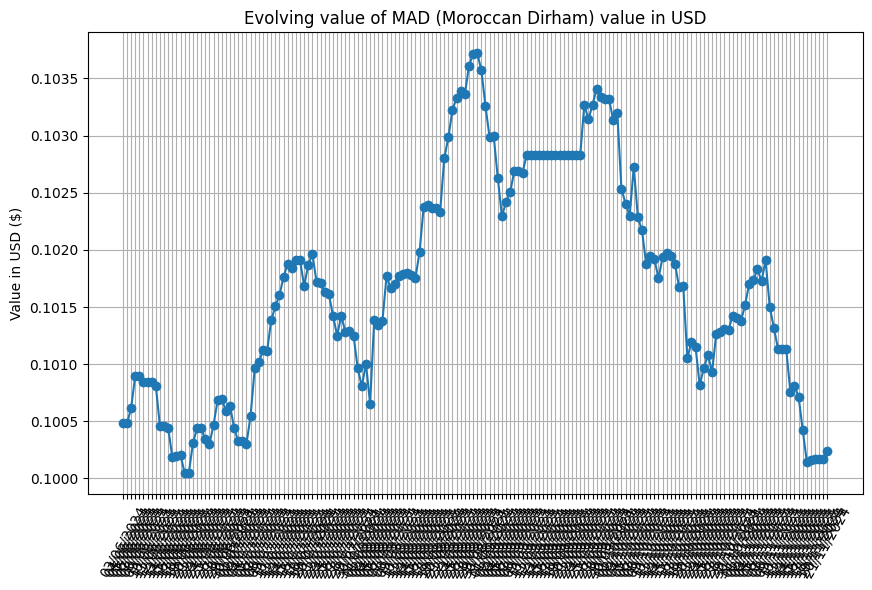

In [ ]:
plot_currency_evolution(concatenated_df, currency_code="MAD")